In [ ]:
try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np
try:
    import matplotlib.pyplot as plt
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt

data_dir = "new/exponential"

prescribed = np.loadtxt(f"{data_dir}/Prescribed_Replicas.csv", delimiter = ",", dtype = str, skiprows = 1)
instatiated = np.loadtxt(f"{data_dir}/Total_Pods_Instanciated.csv", delimiter = ",", dtype = str, skiprows = 1)

queue = np.loadtxt(f"{data_dir}/Queue_Metrics.csv", delimiter = ",", dtype = str, skiprows = 1)

In [16]:
prescribed_x = prescribed[:, 0].astype(int) / 1000
prescribed_y = prescribed[:, 1].astype(float)

instatiated_x = instatiated[:, 0].astype(int) / 1000
instatiated_y = instatiated[:, 1].astype(float)

In [17]:
def make_incremental(array):
    start = array[0]
    for i in range(len(array)):
        array[i] = array[i] - start
    return array
    
def make_cumulative(array):
    cumulative = []
    cumulative.append(array[0])
    for i in range(1, len(array)):
        cumulative.append(array[i] + cumulative[-1])
    return cumulative

In [18]:
start_time_p = prescribed_x[0]
start_time_i = instatiated_x[0]
for i in range(len(prescribed_x)):
    prescribed_x[i] = prescribed_x[i] - start_time_p

for i in range(len(instatiated_x)):
    instatiated_x[i] = instatiated_x[i] - start_time_i

Prescribed Sirio Cost: 4045.0
Effective Sirio Cost: 6840.0
Absolute Inefficiency: 2795.0
Relative Inefficiency: 69.10%


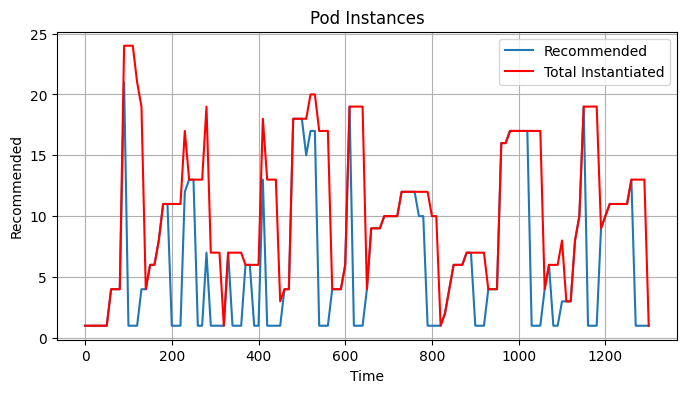

In [19]:
interval = 5
plt.figure(figsize = (8, 4))
plt.plot(prescribed_x, prescribed_y, label = "Recommended")
plt.plot(instatiated_x, instatiated_y, color = "red", label = "Total Instantiated")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Recommended")
plt.title("Pod Instances")

cost_pres = sum(prescribed_y) * interval
cost_insta = sum(instatiated_y) * interval

inefficiency = cost_insta - cost_pres
print(f"Prescribed Sirio Cost: {cost_pres}")
print(f"Effective Sirio Cost: {cost_insta}")
print(f"Absolute Inefficiency: {inefficiency}")
print("Relative Inefficiency: %.2f%%" % (inefficiency/cost_pres * 100))

Text(0.5, 1.0, 'Cost Inefficiency')

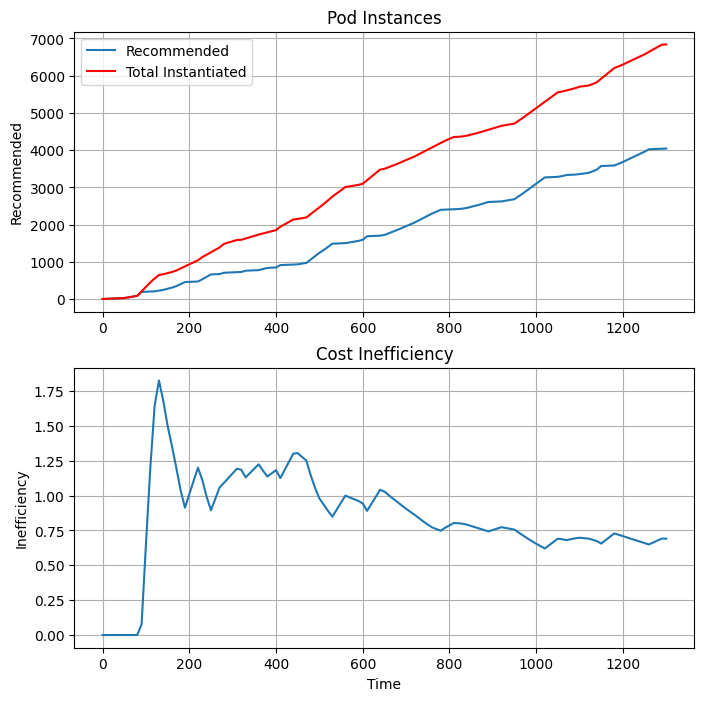

In [20]:
cumulative_prescribed_cost = [0] * len(prescribed_y)
cumulative_effective_cost = [0] * len(instatiated_y)

cumulative_prescribed_cost[0] = prescribed_y[0] * interval
cumulative_effective_cost[0] = instatiated_y[0] * interval
# Iterate up to the minimum length of the two arrays to avoid index errors
loop_range = min(len(prescribed_y), len(instatiated_y))
for i in range(loop_range - 1):
    cumulative_prescribed_cost[i + 1] = cumulative_prescribed_cost[i] + prescribed_y[i + 1] * interval
    cumulative_effective_cost[i + 1] = cumulative_effective_cost[i] + instatiated_y[i + 1] * interval

(fig, ax) = plt.subplots(ncols = 1, nrows = 2, figsize = (8, 8))

ax[0].plot(prescribed_x, cumulative_prescribed_cost, label = "Recommended")
ax[0].plot(instatiated_x, cumulative_effective_cost, color = "red", label = "Total Instantiated")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("Recommended")
ax[0].set_title("Pod Instances")

inefficiency = np.subtract(cumulative_effective_cost, cumulative_prescribed_cost)
relative_inefficiency = inefficiency / cumulative_prescribed_cost

ax[1].plot(prescribed_x, relative_inefficiency)
ax[1].grid()
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Inefficiency")
ax[1].set_title("Cost Inefficiency")

In [21]:
queue_x = make_incremental(queue[:, 0].astype(np.datetime64).astype(int))
queue_msg = queue[:, 1].astype(float)
queue_rej = queue[:, 2].astype(float)

cumulative_msg = np.cumsum(queue_msg)
cumulative_rej = np.cumsum(queue_rej)

np.seterr(invalid = "ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

Text(0.5, 0, 'Time')

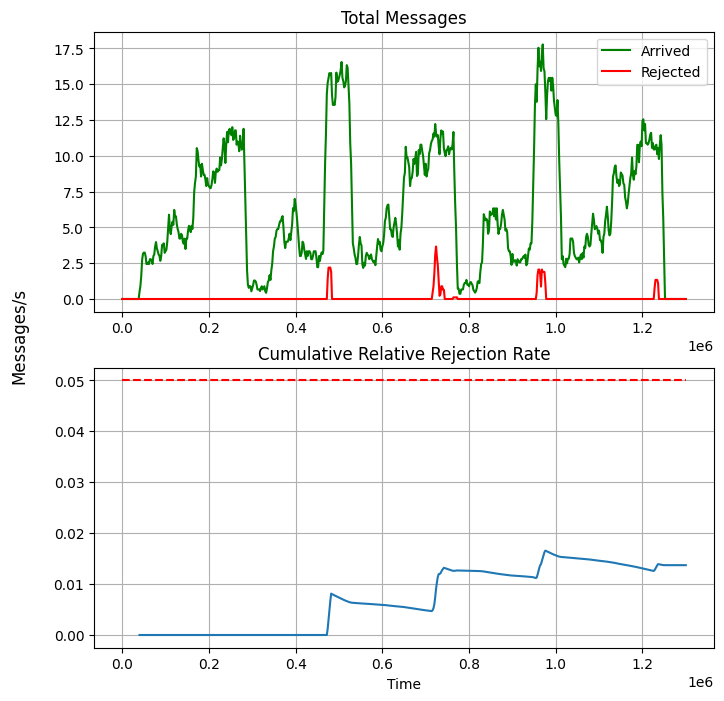

In [22]:
(fig, ax) = plt.subplots(ncols = 1, nrows = 2, figsize = (8, 8))

ax[0].plot(queue_x, queue_msg, color = "green", label = "Arrived")
ax[0].plot(queue_x, queue_rej, color = "red", label = "Rejected")
ax[0].grid()

ax[1].hlines(0.05, min(queue_x), max(queue_x), color = "red", linestyle = "dashed")
ax[1].plot(queue_x, np.divide(cumulative_rej, cumulative_msg))
ax[1].grid(visible = True)

fig.supylabel("Messages/s")

ax[0].set_title("Total Messages")
ax[0].legend()
ax[1].set_title("Cumulative Relative Rejection Rate")
ax[1].set_xlabel("Time")

Text(0.5, 0, 'Time')

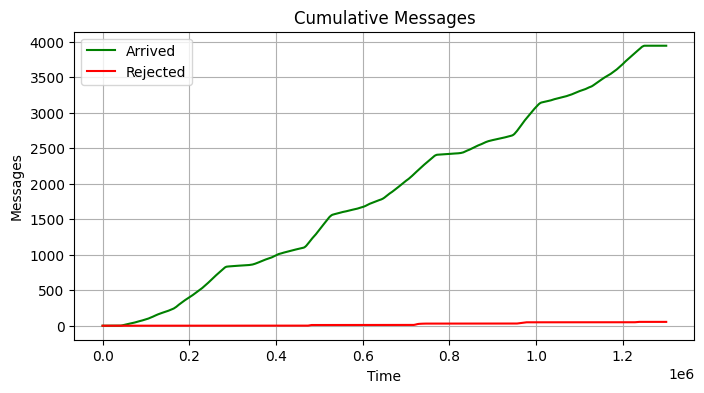

In [23]:
plt.figure(figsize = (8, 4))
plt.plot(queue_x, cumulative_msg, color = "green", label = "Arrived")
plt.plot(queue_x, cumulative_rej, color = "red", label = "Rejected")
plt.grid()

plt.legend()
plt.title("Cumulative Messages")
plt.ylabel("Messages")
plt.xlabel("Time")

In [24]:
total_msg = sum(queue_msg) * 5
total_rej = sum(queue_rej) * 5

actual_rej = total_rej / total_msg
print("Total Rejection Rate: %.2f%%" % (actual_rej * 100))

Total Rejection Rate: 1.37%
